This notebook reads in the PHANGS CO map images and recasts them in deprojected space. Then it calculates the distance from the SNe to the nearest CO 2-1 emission. 

In [16]:
#import packages and initialize settings
import os
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii

plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

import sys
sys.path.append('/home/mayker.1/Desktop/NessPythonFunctions')
from deprojectGalaxy import deproject

In [2]:
# Unpack master table to get SNe information
database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")


In [3]:
# #OPEN CANDIDATE CATALOG AND READ IN RAS, DECS, NAMES
# galaxy = 'NGC4303'
# sne = 'SN1926A'
# image  = '../ALMAmaps/12m+7m+tp_co21_broad_mom0/NGC4303_12m+7m+tp_co21_broad_mom0.fits'
# errimage  = '../ALMAmaps/12m+7m+tp_co21_broad_emom0/NGC4303_12m+7m+tp_co21_broad_emom0.fits'
# alphaCOimg = '../alphaCOmaps/NGC4303_alphaCO21_Sun+20.fits'
# centerCoord = [185.47888, 4.473744]
# # (dist in kpc)
# incl, pa, galDist  = 20.0*u.deg, 310.6*u.deg, 17.6
# SNra, SNdec = 185.48041666666668*u.deg , 4.487972222222222*u.deg
# SNeCoord = [185.48041666666668 , 4.487972222222222]


# Galaxy, SNe = [],[]
# Galaxy.append(galaxy)
# SNe.append(sne)

In [26]:
def int2mass(x, aco, res=150.0):
    area = (res/2.0)**2*np.pi/np.log(2.0)
    y = x * aco * area
    return(y)
    
def mass2int(mass, aco, res=150.0):
    area = (res/2.0)**2*np.pi/np.log(2.0)
    inten = mass / (aco * area)
    return(inten)

def arraySort(variable, distance):
    # sorts variable by shortest distance
    pattern = distance.argsort()
    dist = distance[pattern]
    var = variable[pattern]
    return (var, dist)

def findNearest(varArray, value, SNdistArray):
    # sorts variable by distance, returning closest with given value and that value
    var, SNdist = arraySort(varArray, SNdistArray) 
    ind = np.where(var >= value)
    
    if len(SNdist[ind]) > 0:
        nearestSN    = np.argmin(SNdist[ind])
        nearSNDist   = SNdist[ind][nearestSN] * 1000
        varSNVal     = var[ind][nearestSN]
    else:
        nearSNDist   = float('nan')
        varSNVal     = float('nan')
        
    return(varSNVal, nearSNDist)
    
def printNearest(filestr, kind, value, SNRcutoff = 3.0):
    # takes galaxy name, kind of sorting (SNR, Intensity, or Mass), and value we want (min SNR, intensity, or mass) 
    # and returns distance to the nearest molecular cloud and the min value found of kind requested
    fileName = "/home/mayker.1/Desktop/SNeCO_Data_Products/FlatSNeDistanceMaps/{}FlatSNeData.txt".format(filestr)
    if os.path.isfile(fileName):
        
        flatData = Table.read("/home/mayker.1/Desktop/SNeCO_Data_Products/FlatSNeDistanceMaps/{}FlatSNeData.txt".format(filestr), format = "ascii") 

        #apply SNR cutoff
        intenCut, SNdist_kpcCut, massCut = [],[],[]
        for i in range(len(flatData)):
            if (flatData["SNR"][i] >= SNRcutoff):
                intenCut.append(flatData["Intensity"][i])
                SNdist_kpcCut.append(flatData["distSNe"][i])
                massCut.append(flatData["mass"][i])

        if kind == 'SNR':
            valFound, nearestMCSN = findNearest(np.array(flatData["SNR"]), value, np.array(flatData["distSNe"]))    
        elif kind == 'Intensity':
            valFound, nearestMCSN = findNearest(np.array(intenCut), value, np.array(SNdist_kpcCut))
        else:
            valFound, nearestMCSN = findNearest(np.array(massCut), value, np.array(SNdist_kpcCut))

        return(nearestMCSN, valFound)  
    
    else:
        return(np.float('nan'),np.float('nan'))

In [5]:
inten5  = mass2int(10**5, 6.7)
inten55 = mass2int(10**5.5, 6.7)
inten6  = mass2int(10**6, 6.7)
inten65 = mass2int(10**6.5, 6.7)
inten7  = mass2int(10**7, 6.7)
inten75  = mass2int(10**7.5, 6.7)
print(inten5, inten55, inten6, inten65, inten7, inten75)

0.5854344282657421 1.8513062139982037 5.854344282657421 18.51306213998204 58.543442826574214 185.1306213998204


In [6]:
def getHistVals(kind, value):

    names, nearestMC, valFound = [],[],[]
    
    for i in range(len(database)):
        filestr = database["galaxy"][i] + "_" + database["SN_name"][i] + "_"
        nearMC, val = printNearest(filestr, kind, value)
        names.append(filestr)
        nearestMC.append(nearMC)
        valFound.append(val)
    print("one done!")
    return(names, nearestMC, valFound)


In [7]:
#ONLY RUN IF NECESSARY

# # Set up intensity histograms for different mass MCs with constant alphaCO
# # we take the intensity specified and multiply by alphaCO = 6.7 giving us a generic mass
# kind = 'Intensity'

# galaxy_55_int, nearestMCSN_55_int, valFound_55_int = getHistVals(kind, value=inten55)
# galaxy_6_int,  nearestMCSN_6_int,  valFound_6_int  = getHistVals(kind, value=inten6)
# galaxy_65_int, nearestMCSN_65_int, valFound_65_int = getHistVals(kind, value=inten65)
# galaxy_7_int,  nearestMCSN_7_int,  valFound_7_int  = getHistVals(kind, value=inten7)
# galaxy_75_int, nearestMCSN_75_int, valFound_75_int = getHistVals(kind, value=inten75)

# # Set up intensity histograms for different mass MCs
# #These masses are calculated by multiplying the intensity by jiayi's metallicity dependent
# #alpha CO for each pixel.
# kind = 'Mass'

# galaxy_55_mass, nearestMCSN_55_mass, valFound_55_mass = getHistVals(kind, value=10**5.5)
# galaxy_6_mass,  nearestMCSN_6_mass,  valFound_6_mass  = getHistVals(kind, value=10**6.0)
# galaxy_65_mass, nearestMCSN_65_mass, valFound_65_mass = getHistVals(kind, value=10**6.5)
# galaxy_7_mass,  nearestMCSN_7_mass,  valFound_7_mass  = getHistVals(kind, value=10**7.0)
# galaxy_75_mass, nearestMCSN_75_mass, valFound_75_mass = getHistVals(kind, value=10**7.5)



<ipython-input-4-f548a0991288>:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return(np.float('nan'),np.float('nan'))


one done!
one done!
one done!
one done!
one done!
one done!
one done!
one done!
one done!
one done!


In [34]:
histTable = Table({"Names": galaxy_55_int,
                   "MCSN55Int"    : nearestMCSN_55_int,
                   "MCSN55Intval" : valFound_55_int,
                   "MCSN6Int"     : nearestMCSN_6_int, 
                   "MCSN6Intval"  : valFound_6_int,
                   "MCSN65Int"    : nearestMCSN_65_int,
                   "MCSN65Intval" : valFound_65_int,
                   "MCSN7Int"     : nearestMCSN_7_int, 
                   "MCSN7Intval"  : valFound_7_int,
                   "MCSN75Int"    : nearestMCSN_75_int, 
                   "MCSN75Intval" : valFound_75_int,                   
                   "MCSN55Mass"   : nearestMCSN_55_mass, 
                   "MCSN55Massval": valFound_55_int,
                   "MCSN6Mass"    : nearestMCSN_6_mass, 
                   "MCSN6Massval" : valFound_6_mass,
                   "MCSN65Mass"   : nearestMCSN_65_mass, 
                   "MCSN65Massval": valFound_65_mass,
                   "MCSN7Mass"    : nearestMCSN_7_mass, 
                   "MCSN7Massval" : valFound_7_mass,
                   "MCSN75Mass"   : nearestMCSN_75_mass, 
                   "MCSN75Massval": valFound_75_mass
})

ascii.write(histTable, '../Data/3.HistData.csv', format='csv', fast_writer=False, overwrite=True)  

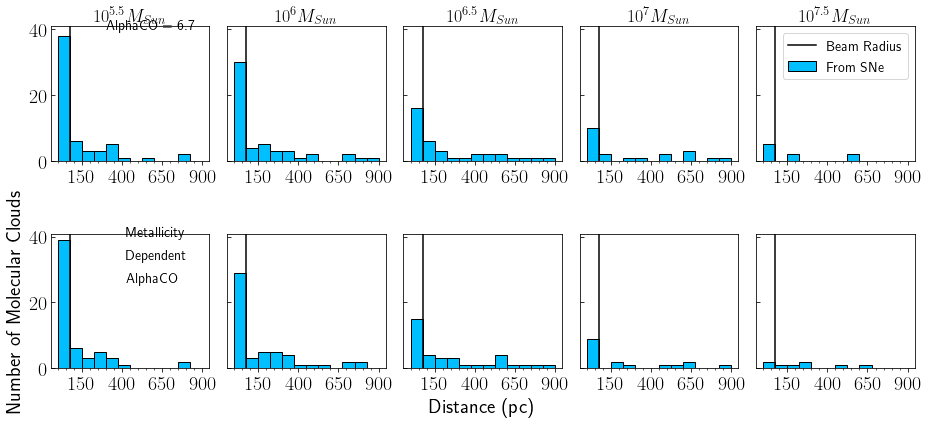

In [20]:
#Plot Histograms

binNum    = [0, 75, 150, 225, 300, 375, 450, 525, 600, 675, 750, 825, 900]
#binNum    = [0, 25,50,75, 100,150, 200, 250, 300, 350, 400, 450, 500, 550,600, 650,700, 750, 800,850, 900]
minorTicks = [0, 50, 100, 200, 250, 300, 350, 450, 500, 550,600, 700, 750, 800,850]
majorTicks = [150,400,650,900]
# minorTicks = [0,75, 225, 300, 375, 450, 600, 675, 750, 825]
# majorTicks = [150, 525, 900]
color1, color2, color3 = 'deepskyblue', 'magenta', 'black'
label1 = 'From SNe'
label3 = 'Beam Radius'
fsize = 18
fig, axs = plt.subplots(2, 5, sharex=False, sharey = True, tight_layout=True)
fig.set_figheight(6)
fig.set_figwidth(13)
plt.tick_params(axis='y', direction = 'in')

axs[0,0].set_title(r'$10^{5.5} M_{Sun}$', fontsize = fsize)
axs[0,0].text(300, 40, 'AlphaCO = 6.7', fontsize=14)
axs[0,0].hist(nearestMCSN_55_int, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,0].axvline(75, color=color3, label = label3)
axs[0,0].set_xticks(ticks=majorTicks)
axs[0,0].set_xticks(ticks=minorTicks, minor=True)
axs[0,0].tick_params(axis='y', direction = 'in')

axs[0,1].set_title(r'$10^{6} M_{Sun}$', fontsize = fsize)
axs[0,1].hist(nearestMCSN_6_int, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,1].axvline(75, color=color3, label = label3)
axs[0,1].set_xticks(ticks=majorTicks)
axs[0,1].set_xticks(ticks=minorTicks, minor=True)
axs[0,1].tick_params(axis='y', direction = 'in')

axs[0,2].set_title(r'$10^{6.5} M_{Sun}$', fontsize = fsize)
axs[0,2].hist(nearestMCSN_65_int, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,2].axvline(75, color=color3, label = label3)
axs[0,2].set_xticks(ticks=majorTicks)
axs[0,2].set_xticks(ticks=minorTicks, minor=True)
axs[0,2].tick_params(axis='y', direction = 'in')

axs[0,3].set_title(r'$10^{7} M_{Sun}$', fontsize = fsize)
axs[0,3].hist(nearestMCSN_7_int, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,3].axvline(75, color=color3, label = label3)
axs[0,3].set_xticks(ticks=majorTicks)
axs[0,3].set_xticks(ticks=minorTicks, minor=True)
axs[0,3].tick_params(axis='y', direction = 'in')

axs[0,4].set_title(r'$10^{7.5} M_{Sun}$', fontsize = fsize)
axs[0,4].hist(nearestMCSN_75_int, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,4].axvline(75, color=color3, label = label3)
axs[0,4].set_xticks(ticks=majorTicks)
axs[0,4].set_xticks(ticks=minorTicks, minor=True)
axs[0,4].tick_params(axis='y', direction = 'in')

axs[1,0].text(425, 26, 'AlphaCO', fontsize=14)
axs[1,0].text(425, 40, 'Metallicity', fontsize=14)
axs[1,0].text(425, 33, 'Dependent', fontsize=14)
axs[1,0].hist(nearestMCSN_55_mass, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,0].axvline(75, color=color3, label = label3)
axs[1,0].set_xticks(ticks=majorTicks)
axs[1,0].set_xticks(ticks=minorTicks, minor=True)
axs[1,0].tick_params(axis='y', direction = 'in')

axs[1,1].hist(nearestMCSN_6_mass, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,1].axvline(75, color=color3, label = label3)
axs[1,1].set_xticks(ticks=majorTicks)
axs[1,1].set_xticks(ticks=minorTicks, minor=True)
axs[1,1].tick_params(axis='y', direction = 'in')

axs[1,2].hist(nearestMCSN_65_mass, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,2].axvline(75, color=color3, label = label3)
axs[1,2].set_xticks(ticks=majorTicks)
axs[1,2].set_xticks(ticks=minorTicks, minor=True)
axs[1,2].tick_params(axis='y', direction = 'in')

axs[1,3].hist(nearestMCSN_7_mass, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,3].axvline(75, color=color3, label = label3)
axs[1,3].set_xticks(ticks=majorTicks)
axs[1,3].set_xticks(ticks=minorTicks, minor=True)
axs[1,3].tick_params(axis='y', direction = 'in')

axs[1,4].hist(nearestMCSN_75_mass, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,4].axvline(75, color=color3, label = label3)
axs[1,4].set_xticks(ticks=majorTicks)
axs[1,4].set_xticks(ticks=minorTicks, minor=True)
axs[1,4].tick_params(axis='y', direction = 'in')

# axs[0,0].legend(loc='best', fontsize = 14)
# axs[0,1].legend(loc='best', fontsize = 14)
# axs[0,2].legend(loc='best', fontsize = 14)
# axs[0,3].legend(loc='best', fontsize = 14)
axs[0,4].legend(loc='best', fontsize = 14)
# axs[1,0].legend(loc='best', fontsize = 14)
# axs[1,1].legend(loc='best', fontsize = 14)
# axs[1,2].legend(loc='best', fontsize = 14)
# axs[1,3].legend(loc='best', fontsize = 14)
# axs[1,4].legend(loc='best', fontsize = 14)

axs[1,0].set_ylabel('Number of Molecular Clouds', fontsize = 20)
axs[1,2].set_xlabel('Distance (pc)', fontsize = 20)

fig.savefig('../Figures/Hist_nearestMCs_withRand.png')


In [27]:
#ONLY RUN IF NECESSARY

# Set up intensity histograms for different mass MCs with constant alphaCO
kind = 'SNR'

# galaxy_SNR_1,    nearestMCSN_SNR_1,   valFound_SNR_1   = getHistVals(kind, value=1)
# galaxy_SNR_3,    nearestMCSN_SNR_3,   valFound_SNR_3   = getHistVals(kind, value=3)
# galaxy_SNR_5,    nearestMCSN_SNR_5,   valFound_SNR_5   = getHistVals(kind, value=5)
galaxy_SNR_70,   nearestMCSN_SNR_70,  valFound_SNR_70  = getHistVals(kind, value=70)
galaxy__SNR_200, nearestMCSN_SNR_200, valFound_SNR_200 = getHistVals(kind, value=200)


<ipython-input-26-7531a34c9268>:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return(np.float('nan'),np.float('nan'))


one done!
one done!
one done!


KeyboardInterrupt: 

In [35]:
histTable.add_column(nearestMCSN_SNR_1, name = "MCSN_SNR_1")
histTable.add_column(valFound_SNR_1,    name = "MCSN_SNR_1_val")
histTable.add_column(nearestMCSN_SNR_3, name = "MCSN_SNR_3")
histTable.add_column(valFound_SNR_3,    name = "MCSN_SNR_3_val")
histTable.add_column(nearestMCSN_SNR_5, name = "MCSN_SNR_5")
histTable.add_column(valFound_SNR_5,    name = "MCSN_SNR_5_val")



In [36]:
histTable

Names,MCSN55Int,MCSN55Intval,MCSN6Int,MCSN6Intval,MCSN65Int,MCSN65Intval,MCSN7Int,MCSN7Intval,MCSN75Int,MCSN75Intval,MCSN55Mass,MCSN55Massval,MCSN6Mass,MCSN6Massval,MCSN65Mass,MCSN65Massval,MCSN7Mass,MCSN7Massval,MCSN75Mass,MCSN75Massval,MCSN_SNR_1,MCSN_SNR_1_val,MCSN_SNR_3,MCSN_SNR_3_val,MCSN_SNR_5,MCSN_SNR_5_val
str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
circinus_SN1996cr_,32.20571074533962,170.42623901367188,32.20571074533962,170.42623901367188,32.20571074533962,170.42623901367188,32.20571074533962,170.42623901367188,32.2670317391334,201.25888061523438,32.20571074533962,170.42623901367188,32.20571074533962,21802756.354290895,32.20571074533962,21802756.354290895,32.20571074533962,21802756.354290895,470.4417934320387,39057194.333950214,32.20571074533962,81.27533721923828,32.20571074533962,81.27533721923828,32.20571074533962,81.27533721923828
ngc0253_SN1940E_,30.57009156537961,219.3036651611328,30.57009156537961,219.3036651611328,30.57009156537961,219.3036651611328,30.57009156537961,219.3036651611328,30.57009156537961,219.3036651611328,30.57009156537961,219.3036651611328,30.57009156537961,25051121.539413508,30.57009156537961,25051121.539413508,30.57009156537961,25051121.539413508,172.50886307740876,32268517.804338302,30.57009156537961,149.6125030517578,30.57009156537961,149.6125030517578,30.57009156537961,149.6125030517578
ngc0300_SN2019qyl_,319.1694138992419,1.927222728729248,nan,nan,nan,nan,nan,nan,nan,nan,291.6161338593793,1.927222728729248,nan,nan,nan,nan,nan,nan,nan,nan,43.2983145368518,1.5906935930252075,68.73226104992987,3.044600486755371,114.04623946350861,5.0091047286987305
ngc0628_SN2019krl_,754.8017888319929,1.9403250217437744,1077.66215004106,5.914911270141602,1384.614046048056,18.693458557128906,nan,nan,nan,nan,754.8017888319929,1.9403250217437744,1096.4684335013435,1018331.5638491693,1403.889831817095,3187967.818395557,nan,nan,nan,nan,3.2356139107476336,1.629622220993042,386.11662360698585,3.004162549972534,781.6694045568804,5.000779151916504
ngc0628_SN2013ej_,97.87335683310963,2.7534096240997314,1041.8493291343557,5.918017864227295,1905.584387738541,18.792024612426758,nan,nan,nan,nan,97.87335683310963,2.7534096240997314,1039.571024101005,1001615.4525589489,1914.4065819586717,3210149.281739499,nan,nan,nan,nan,4.179389857316039,1.5650715827941895,97.87335683310963,3.022393226623535,646.0055360564204,5.020193576812744
ngc1068_SN2018ivc_,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ngc1087_SN1995V_,13.646047502189571,12.753849029541016,13.646047502189571,12.753849029541016,640.3166744441254,18.676807403564453,1876.5354349603913,62.60198211669922,nan,nan,13.646047502189571,12.753849029541016,13.646047502189571,2155723.6181955445,662.2966195489099,3255604.026622281,1907.8347672791663,10467899.071846304,nan,nan,13.646047502189571,14.062186241149902,13.646047502189571,14.062186241149902,13.646047502189571,14.062186241149902
ngc1097_SN1999eu_,556.5599733157865,1.9549763202667236,6423.255336323128,6.406509876251221,6549.959769745981,19.56014060974121,10225.792689872727,59.72481918334961,12849.433533168558,185.25680541992188,279.6432954572124,1.9549763202667236,1073.398364114337,1075777.3188488148,6549.959769745981,3428938.91921302,12018.899771001968,10305676.272910638,12938.86196778994,32904835.093581248,255.44186682169106,1.6444770097732544,279.6432954572124,3.554716110229492,556.5599733157865,5.434122562408447
ngc1097_SN1992bd_,13.211165591673028,260.3741149902344,13.211165591673028,260.3741149902344,13.211165591673028,260.3741149902344,13.211165591673028,260.3741149902344,13.211165591673028,260.3741149902344,13.211165591673028,260.3741149902344,13.211165591673028,27923714.478954595,13.211165591673028,27923714.478954595,13.211165591673028,27923714.478954595,39.223452462985804,37201568.491263494

In [ ]:
#Plot Histograms

binNum = 20

fig, axs = plt.subplots(1, 5, sharex=False, sharey = True, tight_layout=True)
fig.set_figheight(3)
fig.set_figwidth(13)
plt.tick_params(axis='y', direction = 'in')

axs[0].hist(nearestMC_55, bins=binNum, edgecolor='black', label = r'SNR $>$ 1')
axs[0].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[0].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[0].tick_params(axis='y', direction = 'in')

axs[1].hist(nearestMC_6, bins=binNum, edgecolor='black', label = r'SNR $>$ 3')
axs[1].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[1].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[1].tick_params(axis='y', direction = 'in')

axs[2].hist(nearestMC_65, bins=binNum, edgecolor='black', label = r'SNR $>$ 5')
axs[2].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[2].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[2].tick_params(axis='y', direction = 'in')

axs[3].hist(nearestMC_7, bins=binNum, edgecolor='black', label = r'SNR $>$ 70')
axs[3].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[3].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[3].tick_params(axis='y', direction = 'in')

axs[4].hist(nearestMC_75, bins=binNum, edgecolor='black', label = r'SNR $>$ 200')
axs[4].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[4].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[4].tick_params(axis='y', direction = 'in')

axs[0].legend(loc='best', fontsize = 16)
axs[1].legend(loc='best', fontsize = 16)
axs[2].legend(loc='best', fontsize = 16)
axs[3].legend(loc='best', fontsize = 16)
axs[4].legend(loc='best', fontsize = 16)


axs[0].set_ylabel('Number of Supernova', fontsize = 20)
axs[2].set_xlabel('Distance (pc)', fontsize = 20)

fig.savefig('../Figures/Hist_nearestMCs_SNR.png')
print(len(nearestMC_55), len(nearestMC_6), len(nearestMC_65), len(nearestMC_7), len(nearestMC_75))

In [ ]:
!bug!

In [ ]:
from progressbar import ProgressBar

pbar = ProgressBar()

with open('SNeCOMasterCat7m.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Ra,Dec,xCoord,yCoord,Type,numSNe,Intensity7m,IntensityErr7m,EW(7m),beamSize', file = text_file)

for i in pbar(range(len(galaxies))):
    found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, map2,map3, naxis1, naxis2, beamSize = check_in_image(ras, decs, SNe, types, images[i], errFiles[i], ewFiles[i])
    plt.figure(figsize=(7, 7))
    logmap = np.log10(map)
    plt.imshow(map, origin='lower', interpolation='nearest', zorder=1)
    intensity = []
    intensityErr = []
    equivalentWidth = []
    equivalentWidthErr = []
    for k in range(len(found_name)):
        stringPrint = found_name[k] + ': ' + found_type[k]
        stringPrint = found_name[k]
        if (len(found_type[k])>1):
            if found_type[k][1] == "I":
                colorCode = 'chartreuse'
            elif found_type[k][1] == "b" or found_type[k][1] == "c":
                colorCode = 'salmon'
            elif found_type[k][1] == "a":
                colorCode = 'deeppink'
            else:
                colorCode = 'cyan'
        else:
            colorCode = 'slategrey'
        xVal = int(round(x_coord[k]))
        yVal = int(round(y_coord[k]))
        if (yVal <= naxis2) and (xVal <= naxis1):
            intensity.append(map[yVal, xVal])
            intensityErr.append(map2[yVal, xVal])
            equivalentWidth.append(map3[yVal, xVal])

        else: 
            intensity.append(np.nan)
            intensityErr.append(np.nan)
            equivalentWidth.append(np.nan)
        plt.plot(x_coord[k], y_coord[k], '*', ms=15, color=colorCode, zorder=10)
        plt.text(x_coord[k]-1, y_coord[k]+4, stringPrint, fontsize=14, fontweight='bold', color=colorCode)
    plt.axis('off')
    plt.title(galaxies[i], fontsize=24, fontweight='bold')
    plt.tight_layout()
    plt.savefig(galaxies[i] + '.png')
    plt.close()
    with open('SNeCOMasterCat7m.txt', 'a') as text_file:
        for j in range(len(found_name)):
            print(galaxies[i], ",", found_name[j],",", found_ra[j], ",",found_dec[j],",", x_coord[j],",",y_coord[j],",", found_type[j],",",len(found_name),",", intensity[j],",", intensityErr[j],",",equivalentWidth[j],",",beamSize, file = text_file)


pull data value at x * y coord. error files are also available to go pull the same pixel to find uncertainty and add to the table.
check intensity values from ds9 but use puython to get the calue
error files are emom0
can check read me to see if I can find this stuff.

hdulist[0].data

In [ ]:
galaxies = np.loadtxt('PHANGSGalaxies_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
images = np.loadtxt('PHANGSGalaxiesImg_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
errFiles = np.loadtxt('PHANGSGalaxiesImgErr_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
ewFiles = np.loadtxt('PHANGSGalaxiesEW_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
pbar = ProgressBar()


with open('SNeCOMasterCat_12_7_tp.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Ra,Dec,xCoord,yCoord,Type,numSNe,Intensity_12_7_tp,IntensityErr_12_7_tp,EW_12_7_tp', file = text_file)

for i in  pbar(range(len(galaxies))):
    found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, map2,map3, naxis1, naxis2, beamSize = check_in_image(ras, decs, SNe, types, images[i], errFiles[i], ewFiles[i])
    plt.figure(figsize=(7, 7))
    #logmap = np.log10(map)
    plt.imshow(map, origin='lower', interpolation='nearest', zorder=1)
    intensity = []
    intensityErr = []
    equivalentWidth = []
    equivalentWidthErr = []
    for k in range(len(found_name)):
        stringPrint = found_name[k] + ': ' + found_type[k]
        stringPrint = found_name[k]
        if (len(found_type[k])>1):
            if found_type[k][1] == "I":
                colorCode = 'black'
            elif found_type[k][1] == "b" or found_type[k][1] == "c":
                colorCode = 'crimson'
            elif found_type[k][1] == "a":
                colorCode = 'purple'
            else:
                colorCode = 'cyan'
        else:
            colorCode = 'blue'
        xVal = int(round(x_coord[k]))
        yVal = int(round(y_coord[k]))
        if (yVal <= naxis2) and (xVal <= naxis1):
            intensity.append(map[yVal, xVal])
            intensityErr.append(map2[yVal, xVal])
            equivalentWidth.append(map3[yVal, xVal])

        else: 
            intensity.append(np.nan)
            intensityErr.append(np.nan)
            equivalentWidth.append(map3[yVal, xVal])
        plt.plot(x_coord[k], y_coord[k], '*', ms=15, color=colorCode, zorder=10)
        plt.text(x_coord[k]-1, y_coord[k]+4, stringPrint, fontsize=14, fontweight='bold', color=colorCode)
    plt.axis('off')
    plt.title(galaxies[i], fontsize=28, fontweight='bold')
    plt.tight_layout()
    plt.savefig(galaxies[i] + '.png')
    plt.close()
    with open('SNeCOMasterCat_12_7_tp.txt', 'a') as text_file:
        for j in range(len(found_name)):
            print(galaxies[i], ",", found_name[j],",", found_ra[j], ",",found_dec[j],",", x_coord[j],",",y_coord[j],",", found_type[j],",",len(found_name),",", intensity[j],",", intensityErr[j],",",equivalentWidth[j], file = text_file)


In [ ]:
# makeFlatHist takes in an image file and returns a sorted array of 
# each intensity value in map. This function removes NANs and turns
# negative intensity values into zeroes
def makeFlatHist(imageFile):
    hdulist = pyfits.open(imageFile)
    map = hdulist[0].data
    intensities = np.ndarray.flatten(map)
    sortInt = np.sort(intensities)
    idx = np.isfinite(sortInt)
    galData = sortInt[idx]
    #galData[galData < 0.0] = 0
    return(galData)
   
# findIntensity takes the intensity of the SN and matches it with 
# the last time that intensity occurs in the sorted array 
def findIntensity(SNInt, galInts):
    galZeroes, galVals = [],[]
    lowestNoise = galInts[0]
    #set all noise terms = 0 (noise is lowest value reflected around zero)
    #sort into zeroes array and intensity values array
    for i in range(len(galInts)):
        if np.fabs(galInts[i]) <= np.fabs(lowestNoise):
            galInts[i] = 0.0
            galZeroes.append(0.0)
        else:
            galVals.append(galInts[i])
    #Find percentile
    found = None
    if SNInt <= np.fabs(lowestNoise):
        foundProb = 0.0
    else:
        for i in range(len(galVals)):
            if galVals[i] == SNInt:
                found = i
        prob = np.linspace(0.0,1.0,len(galVals))
        foundProb = prob[found]
    return(galZeroes, galVals, lowestNoise, foundProb)

In [ ]:
imgFile = "12m+7m+tp_co21_broad_mom0/ngc4303_12m+7m+tp_co21_broad_mom0.fits"
SNInt = 5.85764611457112
SNName = "SN1999gn"

sortArray = makeFlatHist(imgFile)
zeroes, vals, noise, probability = findIntensity(SNInt, sortArray)

print(SNName, probability)

In [ ]:
SNeName, GalaxyName, Intensity, SNType = np.genfromtxt('SNeCOMasterCat_12_7_tp.txt', dtype = str, delimiter = ' , ', unpack=True, usecols = (1,0,8,6))

fltInten = [float(i) for i in Intensity]

Sne, galName, inten, sneType, GalaxyFile = [],[],[],[],[]

#Remove SNe from sample that aren't in map coverage
for i in range(len(SNeName)):
    if np.isfinite(fltInten[i]):
        Sne.append(SNeName[i])
        galName.append(GalaxyName[i])
        inten.append(fltInten[i])
        sneType.append(SNType[i])

#create list of galaxy file names
for i in range(len(galName)):
    if galName[i] == 'circinus':
        string = "12m+7m+tp_co21_broad_mom0/circinus_7m+tp_co21_broad_mom0.fits"
    elif galName[i] == 'ngc0253':
        string = '12m+7m+tp_co21_broad_mom0/ngc0253_7m+tp_co21_broad_mom0.fits'
    elif galName[i] == 'ngc2775':     
        string = '12m+7m+tp_co21_broad_mom0/ngc2775_12m+7m_co21_broad_mom0.fits'
    else:
        string = '12m+7m+tp_co21_broad_mom0/'+galName[i]+'_12m+7m+tp_co21_broad_mom0.fits'
    GalaxyFile.append(string)
    
percentile, medianInten, maxInten, noiseArray = [],[],[],[]

for i in range(len(Sne)):
    sortArray   = makeFlatHist(GalaxyFile[i])
    zeroes, vals, noise, probability = findIntensity(inten[i], sortArray)
    percentile.append(probability)
    noiseArray.append(noise)
    medianInten.append(np.median(vals)) 
    maxInten.append(sortArray[-1])
    
with open('CDF_Vals.txt', 'w') as text_file:
    print('#Galaxy, SNe, Type, Percentile, Intensity, MaxIntensity, Noise', file=text_file)
    for j in range(len(Sne)):
        print(galName[j], ' ', Sne[j], ' ', sneType[j], ' ', percentile[j], ' ', inten[j], maxInten[j], noiseArray[j], file = text_file)

In [ ]:
sortPerc = np.sort(percentile)
xvals = np.linspace(0,1,len(percentile))
maxRatio, medRatio = [],[]
#These should be arrays
for i in range(len(sortPerc)):
    maxRatio.append(inten[i]/maxInten[i])
    medRatio.append(inten[i]/medianInten[i])

maxRatio = np.sort(maxRatio)
medRatio = np.sort(medRatio)

unknown, sortTypeII, sortTypeIa, sortTypeSE = [],[],[],[]
uknMaxRat, TypeIIMaxRat, TypeIaMaxRat, TypeSEMaxRat = [],[],[],[]
uknMedRat, TypeIIMedRat, TypeIaMedRat, TypeSEMedRat = [],[],[],[]

# Type I and 'no' sorted as unknown
for i in range(len(sneType)):
    if (len(sneType[i]) == 1 or sneType[i] == 'no'):
        unknown.append(sortPerc[i])
        uknMaxRat.append(maxRatio[i])
        uknMedRat.append(medRatio[i])
    elif sneType[i][1] == "I":
        sortTypeII.append(sortPerc[i])
        TypeIIMaxRat.append(maxRatio[i])
        TypeIIMedRat.append(medRatio[i])
    elif sneType[i][1] == "a":
        sortTypeIa.append(sortPerc[i])
        TypeIaMaxRat.append(maxRatio[i])
        TypeIaMedRat.append(medRatio[i])
    elif sneType[i][1] == "b" or sneType[i][1] == "c":
        sortTypeSE.append(sortPerc[i]) 
        TypeSEMaxRat.append(maxRatio[i])
        TypeSEMedRat.append(medRatio[i])
            
xvalsII = np.linspace(0,1,len(sortTypeII))
xvalsIa = np.linspace(0,1,len(sortTypeIa))
xvalsSE = np.linspace(0,1,len(sortTypeSE))  
xvalsNo = np.linspace(0,1,len(unknown))    
print(len(sortPerc), len(sortTypeII), len(sortTypeIa),len(sortTypeSE),len(unknown))
    
fig = plt.figure(figsize = (7,5))
plt.tick_params(axis='both', direction='in')
plt.plot(sortPerc, xvals, ls='-', marker='o', color='black', label = 'All')
plt.plot(sortTypeII, xvalsII, ls='-.', marker='*',ms=9, color='purple', label = 'Type II')
plt.plot(sortTypeIa, xvalsIa, ls=':', marker='^', color = 'chocolate', label = 'Type Ia')
plt.plot(sortTypeSE, xvalsSE, ls='-', marker='o',color='green',label = 'Type Ib/c')
plt.plot(unknown, xvalsNo, ls='-', marker='<',label = 'Untyped')
plt.axhline(y=0.16, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.50, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.84, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.grid('both','both',color='k',alpha = 0.05, linestyle='-', linewidth=2)
plt.ylabel('Fraction of SNe', fontsize = 20)
plt.xlabel('Host Galaxy CO 2-1 Intensity Fraction', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
fig.savefig('COIntCDF.png')

fig = plt.figure(figsize = (7,5))
plt.tick_params(axis='both', direction='in')
plt.plot(maxRatio, xvals, ls='-', marker='o', color='black', label = 'All')
plt.plot(TypeIIMaxRat, xvalsII, ls='-.', marker='*',ms=9, color='purple', label = 'Type II')
plt.plot(TypeIaMaxRat, xvalsIa, ls=':', marker='^', color = 'chocolate', label = 'Type Ia')
plt.plot(TypeSEMaxRat, xvalsSE, ls='-', marker='o',color='green',label = 'Type Ib/c')
plt.plot(uknMaxRat, xvalsNo, ls='-', marker='<',label = 'Untyped')
plt.axhline(y=0.16, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.50, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.84, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.grid('both','both',color='k',alpha = 0.05, linestyle='-', linewidth=2)
plt.ylabel('Fraction of SNe', fontsize = 20)
plt.xlabel('Host Galaxy CO 2-1 Intensity / Maximum Fraction', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
fig.savefig('MaxRatioCDF.png')

fig = plt.figure(figsize = (7,5))
plt.tick_params(axis='both', direction='in')
plt.plot(medRatio, xvals, ls='-', marker='o', color='black', label = 'All')
plt.plot(TypeIIMedRat, xvalsII, ls='-.', marker='*',ms=9, color='purple', label = 'Type II')
plt.plot(TypeIaMedRat, xvalsIa, ls=':', marker='^', color = 'chocolate', label = 'Type Ia')
plt.plot(TypeSEMedRat, xvalsSE, ls='-', marker='o',color='green',label = 'Type Ib/c')
plt.plot(uknMedRat, xvalsNo, ls='-', marker='<',label = 'Untyped')
plt.axhline(y=0.16, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.50, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.84, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.grid('both','both',color='k',alpha = 0.05, linestyle='-', linewidth=2)
plt.ylabel('Fraction of SNe', fontsize = 20)
plt.xlabel('Host Galaxy CO 2-1 Intensity / Median Fraction', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
fig.savefig('MedRatioCDF.png')